# AR Punks
Using an Auto Encoder to generate new punks from old

In [2]:
import sys
sys.path.append('..')
sys.path.append('/home/tnn1t1s/art/cpunks-10k')

import numpy as np
import pandas as pd
import pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.animation as animation

%matplotlib inline
plt.style.use('default')
from matplotlib.colors import rgb2hex
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import cpunks.cpunks10k as cpunks10k
import cpunks.utils as cputils

import os
#os.environ["CUDA_VISIBLE_DEVICES"]="1"    
import tensorflow as tf

In [4]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

In [5]:
cp = cpunks10k.cpunks10k()
(X_train, Y_train), (X_test, Y_test), (labels) = cp.load_data()
X = np.concatenate((X_train, X_test), axis=0)
df = cp.punks_df

### meta parameters

In [6]:
class ContextManager(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


In [7]:
def r_loss(y_true, y_pred):
            return K.mean(K.square(y_true - y_pred), axis = [1,2,3])
ctx = ContextManager({})
ctx.r_loss = r_loss
ctx.learning_rate = 0.0005
ctx.batch_size = 32
ctx.initial_epoch = 0
ctx.input_dim = (24, 24, 4)
ctx.encoder_conv_filters = [32, 64, 64, 64]
ctx.encoder_conv_kernel_size = [3,3,3,3]
ctx.encoder_conv_strides = [1,2,2,1]
ctx.decoder_conv_t_filters = [64,64,32,4]
ctx.decoder_conv_t_kernel_size = [3,3,3,3]
ctx.decoder_conv_t_strides = [1,2,2,1]
ctx.z_dim = 4
ctx.n_layers_encoder = len(ctx.encoder_conv_filters)
ctx.n_layers_decoder = len(ctx.decoder_conv_t_filters)


In [9]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [11]:
encoder_input = Input(shape=ctx.input_dim, 
                      name='encoder_input')

x = encoder_input

for i in range(ctx.n_layers_encoder):
    conv_layer = Conv2D(filters = ctx.encoder_conv_filters[i],
                        kernel_size = ctx.encoder_conv_kernel_size[i],
                        strides = ctx.encoder_conv_strides[i],
                        padding = 'same',
                        name = 'encoder_conv_' + str(i))
    x = conv_layer(x)
    x = LeakyReLU()(x)
    
shape_before_flattening = K.int_shape(x)[1:]
x = Flatten()(x)
encoder_output= Dense(ctx.z_dim, name='encoder_output')(x)
encoder = Model(encoder_input, encoder_output)


### The Decoder

In [12]:
decoder_input = Input(shape=(ctx.z_dim,), name='decoder_input')

x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x)

for i in range(ctx.n_layers_decoder):
    conv_t_layer = Conv2DTranspose(filters = ctx.decoder_conv_t_filters[i],
                                   kernel_size = ctx.decoder_conv_t_kernel_size[i],
                                   strides = ctx.decoder_conv_t_strides[i],
                                   padding = 'same',
                                   name = 'decoder_conv_t_' + str(i))
    x = conv_t_layer(x)
    if i < ctx.n_layers_decoder - 1:
        x = LeakyReLU()(x)
        #x = BatchNormalization()(x)
        #x = Dropout(rate = 0.25)(x)
    else:
        x = Activation('sigmoid')(x)

decoder_output = x
decoder = Model(decoder_input, decoder_output)


### Combine to Build the Autoencoder

In [13]:
model_input = encoder_input
model_output = decoder(encoder_output)

model = Model(model_input, model_output)


### Compile

In [14]:
def r_loss(y_true, y_pred):
            return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

In [15]:
optimizer = Adam(learning_rate=ctx.learning_rate)
model.compile(optimizer=optimizer, loss = r_loss)

### Train

In [16]:
from tensorflow.keras.callbacks import Callback, LearningRateScheduler

In [17]:
def step_decay_schedule(initial_lr, decay_factor=0.5, step_size=1):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        new_lr = initial_lr * (decay_factor ** np.floor(epoch/step_size))

        return new_lr

    return LearningRateScheduler(schedule)




In [18]:
epochs = 20

initial_epoch = 0
lr_decay = 1

lr_sched = step_decay_schedule(initial_lr=ctx.learning_rate,
                               decay_factor=lr_decay,
                               step_size=1)

callbacks_list = [lr_sched]

model.fit(X_train,
          X_train,
          batch_size = ctx.batch_size,
          shuffle = True,
          epochs = epochs,
          initial_epoch = initial_epoch,
          callbacks = callbacks_list)

Epoch 1/20


2022-01-31 07:40:25.041288: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8200
2022-01-31 07:40:25.363287: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


282/282 [==============================] - 7s 16ms/step - loss: 0.0463 - lr: 5.0000e-04
Epoch 2/20
282/282 [==============================] - 5s 16ms/step - loss: 0.0214 - lr: 5.0000e-04
Epoch 3/20
282/282 [==============================] - 5s 16ms/step - loss: 0.0179 - lr: 5.0000e-04
Epoch 4/20
282/282 [==============================] - 4s 16ms/step - loss: 0.0159 - lr: 5.0000e-04
Epoch 5/20
282/282 [==============================] - 4s 16ms/step - loss: 0.0145 - lr: 5.0000e-04
Epoch 6/20
282/282 [==============================] - 4s 16ms/step - loss: 0.0136 - lr: 5.0000e-04
Epoch 7/20
282/282 [==============================] - 5s 16ms/step - loss: 0.0130 - lr: 5.0000e-04
Epoch 8/20
282/282 [==============================] - 5s 16ms/step - loss: 0.0126 - lr: 5.0000e-04
Epoch 9/20
282/282 [==============================] - 5s 16ms/step - loss: 0.0121 - lr: 5.0000e-04
Epoch 10/20
282/282 [==============================] - 4s 16ms/step - loss: 0.0117 - lr: 5.0000e-04
Epoch 11/20
282/282 

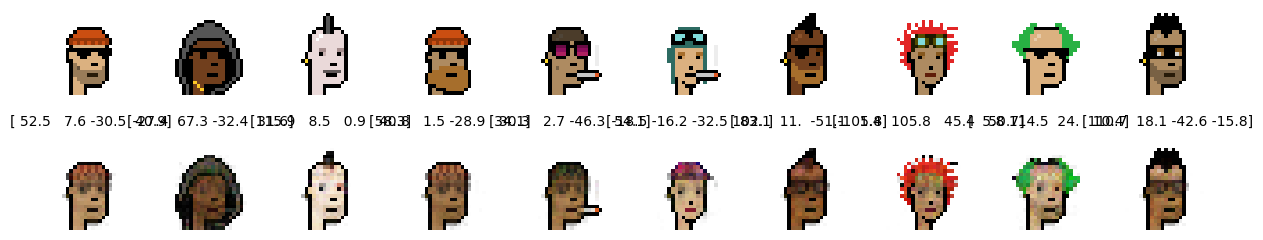

In [19]:
n_to_show = 10
example_idx = np.random.choice(range(len(X_test)), n_to_show)
example_images = X_test[example_idx]

z_points = encoder.predict(example_images)

reconst_images = decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i]#.squeeze()
    ax = fig.add_subplot(2, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=ax.transAxes)   
    ax.imshow(img)

for i in range(n_to_show):
    img = reconst_images[i]#.squeeze()
    ax = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    ax.axis('off')
    ax.imshow(img)

In [20]:
#reconst_images = AE.decoder.predict(z_points)
z_points

array([[  52.53542  ,    7.608099 ,  -30.516832 ,   40.913406 ],
       [ -27.434277 ,   67.33613  ,  -32.38462  ,   31.595358 ],
       [ 115.8967   ,    8.493312 ,    0.9253765,   58.300896 ],
       [  40.846695 ,    1.5217459,  -28.869993 ,   34.066353 ],
       [  30.332561 ,    2.6675012,  -46.254784 ,   54.12702  ],
       [ -18.529625 ,  -16.153698 ,  -32.4733   ,  101.95145  ],
       [  83.075134 ,   11.015237 ,  -51.09091  ,    1.3835558],
       [-105.80394  ,  105.76055  ,   45.367508 ,   50.74965  ],
       [   5.826969 ,  114.51572  ,   24.020369 ,   10.350016 ],
       [ 110.71733  ,   18.068203 ,  -42.601883 ,  -15.762604 ]],
      dtype=float32)

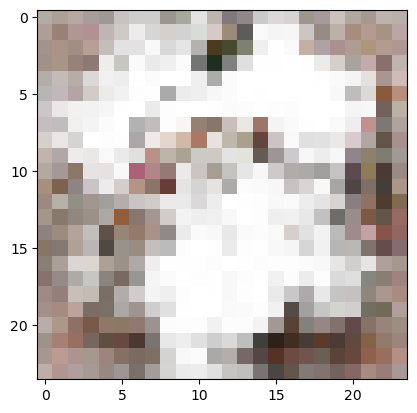

In [21]:
z_s = np.array([[  7.350558  , -13.799404  ,  -2.4654112 ,  -6.299609  ]])
reconst_images = decoder.predict(z_s)
plt.imshow(reconst_images[0])

### pick two punks and do the old face morph trick 

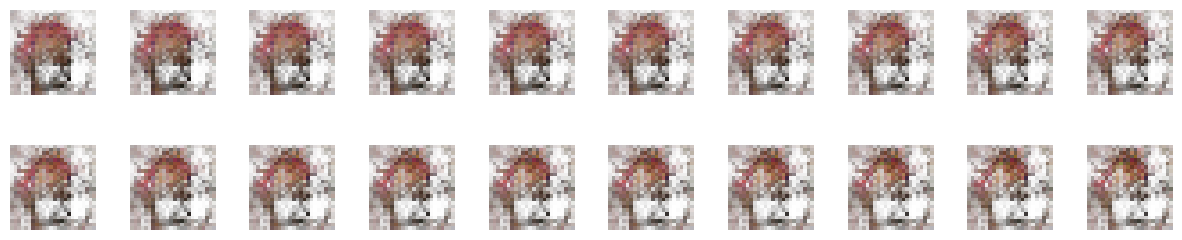

In [22]:
punk_x_img = example_images[0]
punk_y_img = example_images[8]
punk_x_coords = [  7.350558  , -13.799404  ,  -2.4654112 ,  -6.299609  ]
punk_y_coords = [-10.365253  , -11.024603  ,  16.105639  ,   3.2864196 ]

punk_x_coords = [ 10.241212  ,   8.368749  ,   4.796343  ,  -5.5694203 ]
punk_y_coords = [ 12.844572  ,   1.8600631 ,  10.4856    ,  -6.2996225 ]

M=20
x = punk_x_coords
y = punk_y_coords
x = zip(np.linspace(x[0],y[0],M),
        np.linspace(x[1],y[1],M),
        np.linspace(x[2],y[2],M),
        np.linspace(x[3],y[3],M),
       )
z_s = np.array(list(x))
reconst_images = decoder.predict(z_s)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(M):
    img = reconst_images[i]
    ax = fig.add_subplot(2, n_to_show, i+1)
    ax.axis('off')
    ax.imshow(img)

In [23]:
imgs_reversed = np.array([reconst_images[i] for i in range(len(reconst_images) - 1, -1, -1)])
imgs = np.concatenate((reconst_images, imgs_reversed))

In [24]:
import matplotlib.animation as animation
%matplotlib qt

imagelist=imgs 
fig = plt.figure() # make figure

# make axesimage object
# the vmin and vmax here are very important to get the color map correct
im = plt.imshow(imagelist[0]) #, cmap=plt.get_cmap('jet'), vmin=0, vmax=255)

# function to update figure
def updatefig(j):
    # set the data in the axesimage object
    im.set_array(imagelist[j])
    # return the artists set
    return [im]
# kick off the animation
ani = animation.FuncAnimation(fig, updatefig, frames=range(40), 
                             interval=48)
plt.show()

In [29]:
writer = animation.PillowWriter(fps=25)  
ani.save("../tmp/demo.gif", writer=writer) 

## Reducing Dimensions and staying true to the colorpunx

In [32]:
(mnist_x_train, mnist_y_train), (mnist_x_test, minst_y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [37]:
type(mnist_x_train[0][0][0])

numpy.uint8

In [68]:
type(X_train[0][0][0][0])

numpy.float32

In [143]:
import pickle

class CryptoPunksColorMap:
    def __init__(self):
        with open(f"../data/_colors_count.pickle", 'rb') as f:
            self.colors_count = pickle.load(f)
            self.colors = list(self.colors_count.keys())
            self.color_d = {}
            i=0
            for k in self.colors:
                self.color_d[k] = i
                i+=1
    
    def flatten(self, img):
        return np.array([[self.colors_d[str(c)] for c in row]
                                    for row in img]).astype(np.uint8)
    
    def unflatten(self,img):
        return np.array([[np.fromstring(self.colors[c][1:-1], float, sep=' ') for c in row]
                                                                       for row in img])

cpm = CryptoPunksColorMap()